Mounted at /content/drive
Files in /content/drive/MyDrive/Capstone Data/Final Data: ['tax_to_gdp_2009_2023.csv', 'population_growth_cleaned.csv', 'Filtered_Unemployment_Rate.csv', 'Filtered_Real_Interest_Rates_Final.csv', 'Filtered_FDI_2010_2023.csv', 'export_of_goods_and_services___GDP (1).csv', 'Cleaned_GDP_Per_Capita_Data_2010_2023 - Cleaned_GDP_Per_Capita_Data_2010_2023.csv', 'clean_labor_force_participation_rate_modeled.csv', 'clean_inflation_rate (2).csv', 'clean_import_of_goods_and_services_as_a_percentage_of_GDP (1).csv', 'Annual Labor Force Survey.csv', 'Tax_Revenue_2010_2023_updated - Tax_Revenue_2010_2023_updated.csv', 'filtered_urban_population(% of total polpulation) - filtered_urban_population(% of total polpulation).csv', 'Average Wage Data  - Average Wage Data .csv', 'filtered_gdp_usd (1).csv', 'WUI_Annual_Averages_2009_2023_Pivot (1).gsheet', 'CPI.csv', 'filtered_corruption_score(0-100).csv', '.ipynb_checkpoints', 'Public_Sector_Debt.csv', 'regression_results_significa

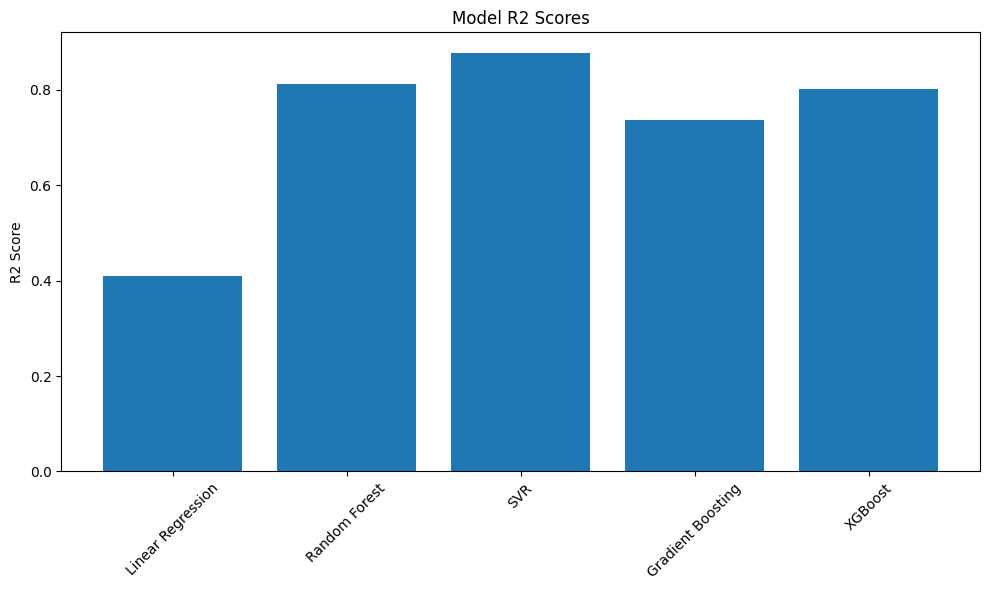

Using exogenous features for ARIMAX: ['Inflation_Rate', 'GDP_Per_Capita', 'Unemployment_Rate', 'Population_Growth', 'Corruption', 'Country_USA']

ARIMAX Forecast Results (2024–2030):
    CCode  Year  Public_Sector_Debt_Forecast
0     AUS  2024                    34.301353
1     AUS  2025                    33.950422
2     AUS  2026                    33.653481
3     AUS  2027                    33.398960
4     AUS  2028                    33.178375
..    ...   ...                          ...
142   NLD  2026                    41.612919
143   NLD  2027                    40.949458
144   NLD  2028                    40.374458
145   NLD  2029                    39.871333
146   NLD  2030                    39.427399

[147 rows x 3 columns]


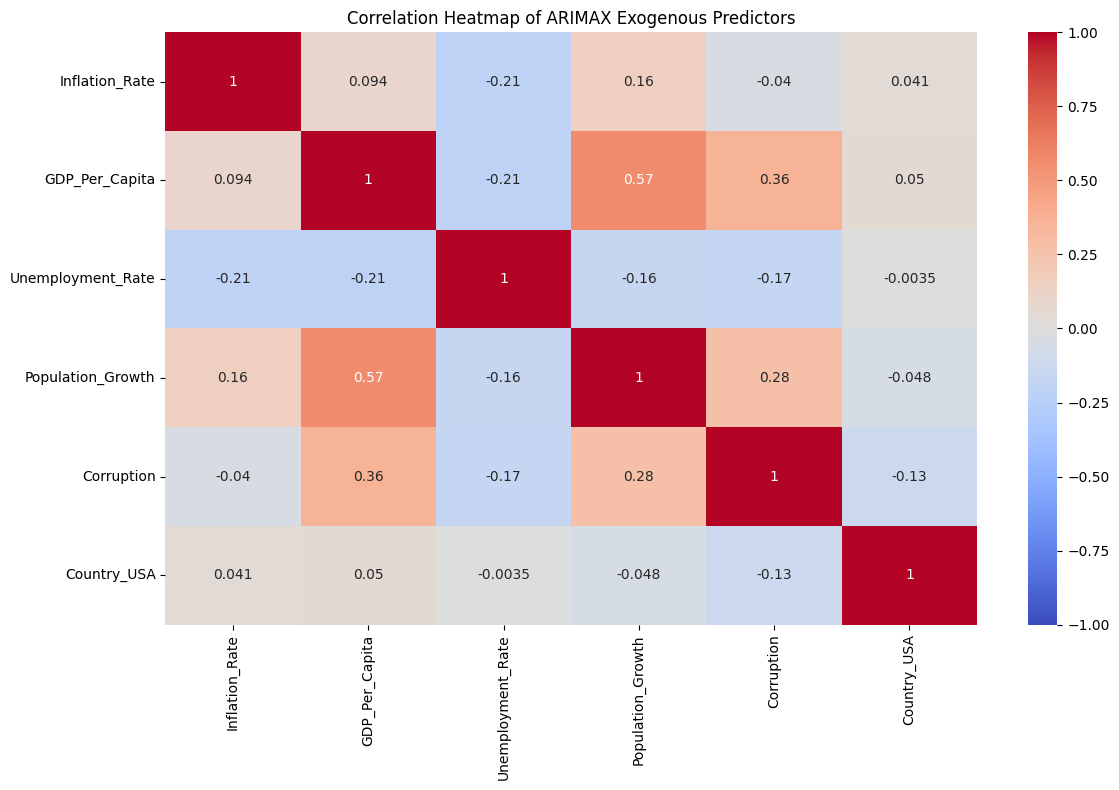


Debt Risk Scores (2023–2030):
   CCode   Debt_2023   Debt_2030  Percent_Change_2023_2030       Score
11   JPN  205.613846  229.247895                 11.494386  100.000000
19   USA  112.256760  116.249728                  3.556995   66.865458
10   ITA  131.694895  128.989482                 -2.054304   65.713588
6    FRA   92.304948   93.895051                  1.722663   59.631166
2    BEL   87.227399   87.794936                  0.650640   57.119340
5    FIN   75.825046   76.142879                  0.419166   53.890310
18   GBR  100.527068   93.151166                 -7.337230   51.733197
12   KOR   48.852372   50.377276                  3.121455   49.853844
1    AUT   58.948238   58.396559                 -0.935870   47.988861
13   LUX   20.812468   22.015891                  5.782223   45.493143
17   CHE   14.710348   15.015589                  2.075012   39.793551
0    AUS   34.832823   32.815059                 -5.792710   36.319210
15   NOR   13.815149   13.504751              

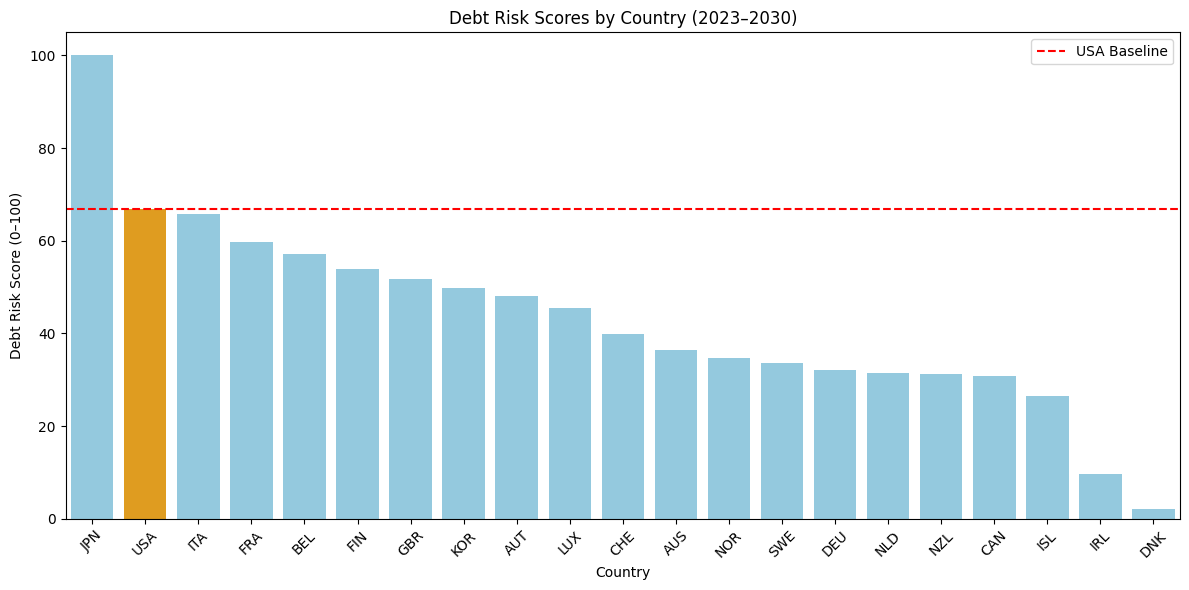

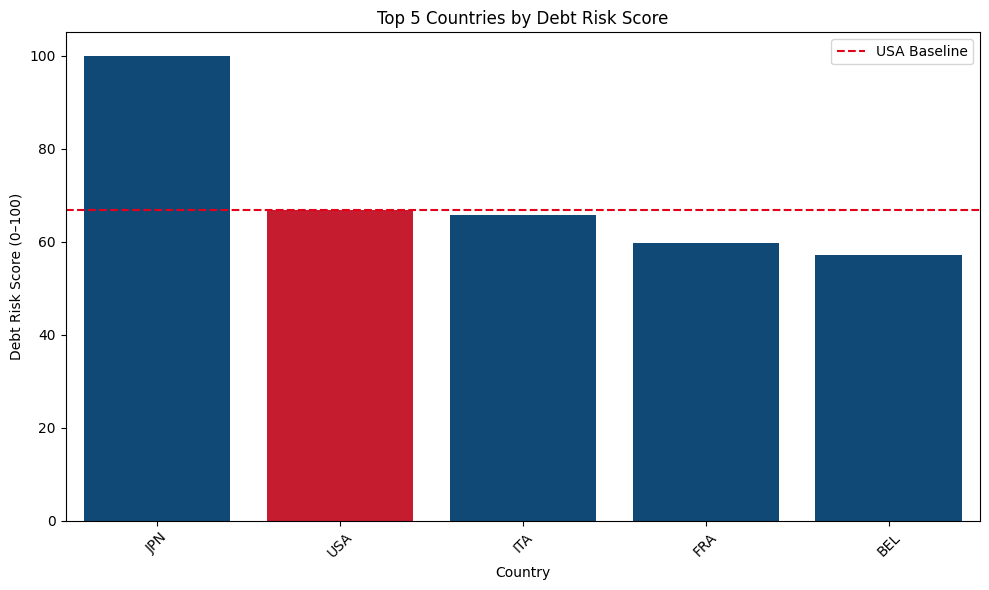

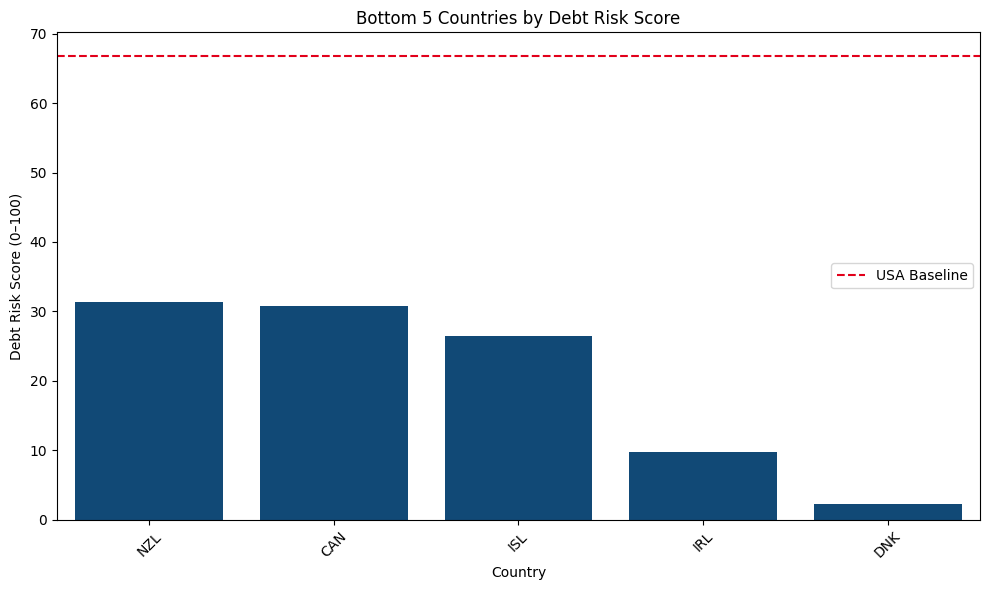

Available countries: ['AUS', 'AUT', 'BEL', 'CAN', 'CHE', 'DEU', 'DNK', 'FIN', 'FRA', 'GBR', 'IRL', 'ISL', 'ITA', 'JPN', 'KOR', 'LUX', 'NLD', 'NOR', 'NZL', 'SWE', 'USA']


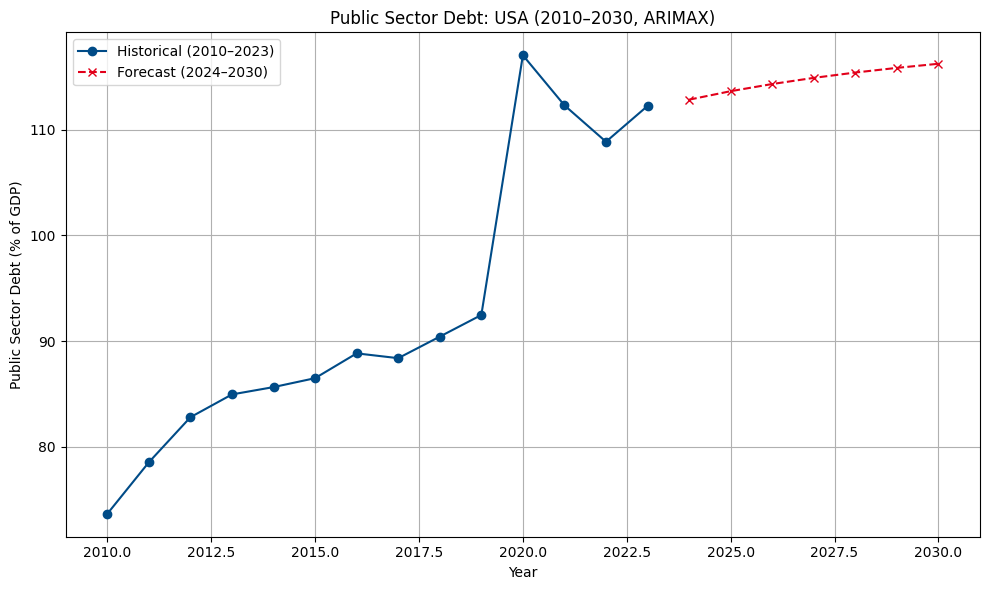

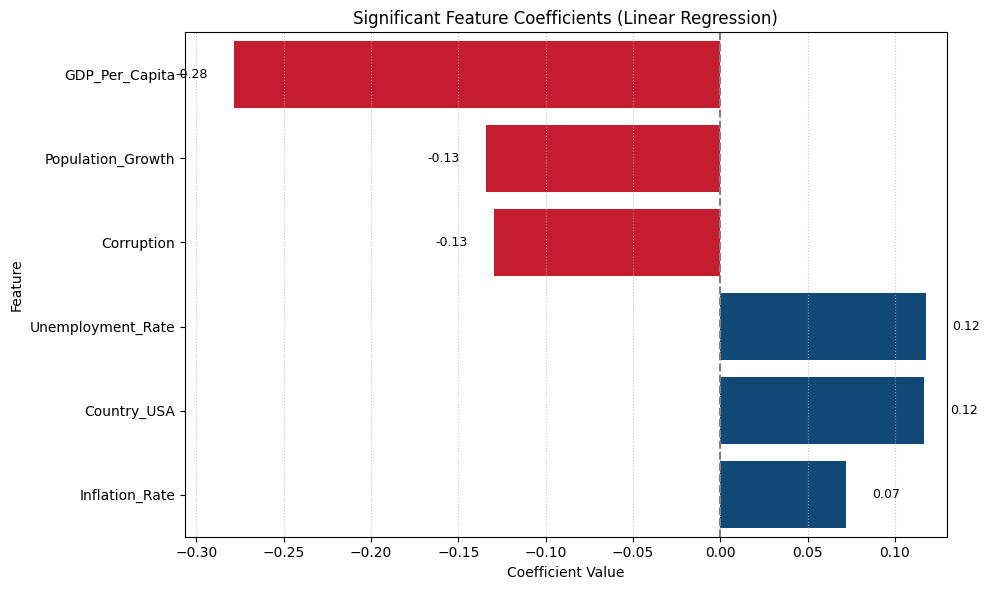

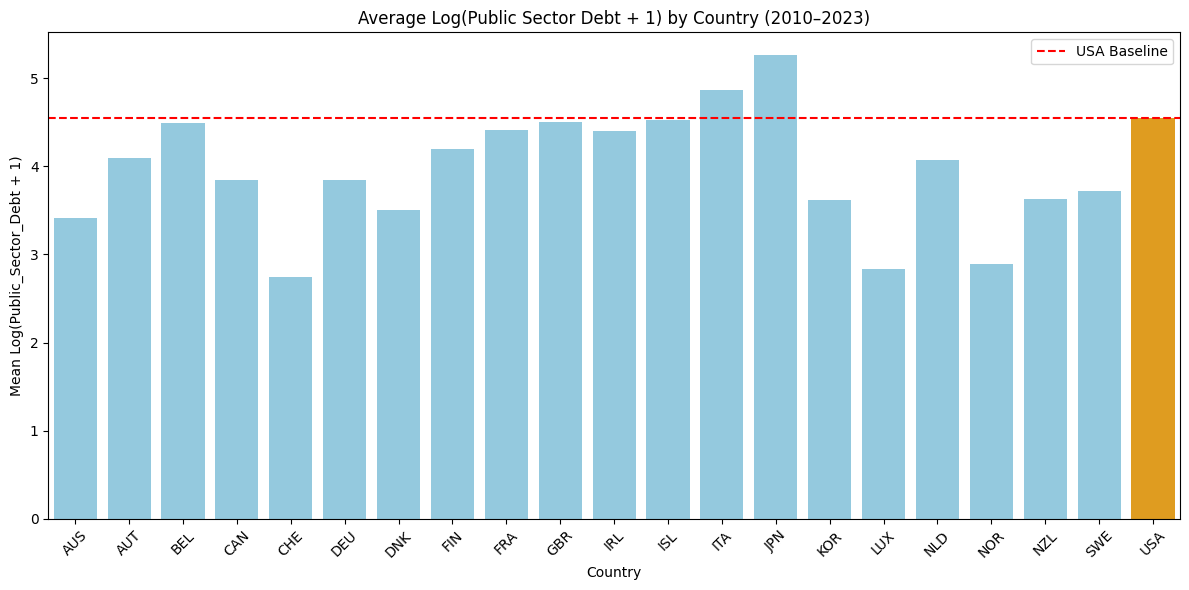

In [6]:
# Install required packages
!pip install xgboost -q

import pandas as pd
import statsmodels.api as sm
import numpy as np
from sklearn.preprocessing import StandardScaler
import os
from datetime import datetime
from functools import reduce
from scipy.stats import shapiro
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.diagnostic import het_breuschpagan
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings('ignore')

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Define paths
data_folder = '/content/drive/MyDrive/Capstone Data/Final Data'
if not os.path.exists(data_folder):
    raise FileNotFoundError(f"Data folder not found: {data_folder}. Contents: {os.listdir('/content/drive/MyDrive')}")
print(f"Files in {data_folder}: {os.listdir(data_folder)}")

files = [
    'Annual Labor Force Survey.csv',
    'clean_import_of_goods_and_services_as_a_percentage_of_GDP (1).csv',
    'clean_inflation_rate (2).csv',
    'clean_labor_force_participation_rate_modeled.csv',
    'Cleaned_GDP_Per_Capita_Data_2010_2023 - Cleaned_GDP_Per_Capita_Data_2010_2023.csv',
    'export_of_goods_and_services___GDP (1).csv',
    'Filtered_FDI_2010_2023.csv',
    'filtered_gdp_usd (1).csv',
    'Filtered_Real_Interest_Rates_Final.csv',
    'Filtered_Unemployment_Rate.csv',
    'population_growth_cleaned.csv',
    'tax_to_gdp_2009_2023.csv',
    'filtered_corruption_score(0-100).csv',
    'Average Wage Data  - Average Wage Data .csv'
]
target_file = 'Public_Sector_Debt.csv'

# Corrected rename_dict
rename_dict = {
    'Annual Labor Force Survey': 'Labor_Force_Survey',
    'clean_import_of_goods_and_services_as_a_percentage_of_GDP (1)': 'Imports_to_GDP',
    'clean_inflation_rate (2)': 'Inflation_Rate',
    'clean_labor_force_participation_rate_modeled': 'Labor_Force_Participation',
    'Cleaned_GDP_Per_Capita_Data_2010_2023 - Cleaned_GDP_Per_Capita_Data_2010_2023': 'GDP_Per_Capita',
    'export_of_goods_and_services___GDP (1)': 'Exports_to_GDP',
    'Filtered_FDI_2010_2023': 'FDI',
    'filtered_gdp_usd (1)': 'GDP_USD',
    'Filtered_Real_Interest_Rates_Final': 'Real_Interest_Rates',
    'Filtered_Unemployment_Rate': 'Unemployment_Rate',
    'population_growth_cleaned': 'Population_Growth',
    'tax_to_gdp_2009_2023': 'Tax_to_GDP',
    'filtered_corruption_score(0-100)': 'Corruption',
    'Average Wage Data  - Average Wage Data ': 'Wage'
}

# Function to load and preprocess data
def load_and_preprocess(file_path):
    try:
        df = pd.read_csv(os.path.join(data_folder, file_path))
        df['CCode'] = df['CCode'].astype(str)
        year_cols = [col for col in df.columns if col not in ['CCode', 'Country', 'Country Name'] and col.isdigit()]
        df_melt = pd.melt(df, id_vars=['CCode'], value_vars=year_cols,
                          var_name='Year', value_name=file_path.split('.')[0])
        df_melt['Year'] = df_melt['Year'].astype(int)
        value_col = file_path.split('.')[0]
        if df_melt[value_col].dtype not in ['float64', 'int64']:
            df_melt[value_col] = pd.to_numeric(df_melt[value_col].astype(str).str.replace(',', ''), errors='coerce')
        if value_col in rename_dict:
            df_melt = df_melt.rename(columns={value_col: rename_dict[value_col]})
        return df_melt
    except Exception as e:
        print(f"Error processing {file_path}: {type(e).__name__} - {str(e)}")
        return None

# Load target variable
target_df = load_and_preprocess(target_file)
if target_df is None:
    raise ValueError("Failed to load target file")
target_df = target_df.rename(columns={target_file.split('.')[0]: 'Public_Sector_Debt'})

# Load all predictor datasets
predictor_dfs = []
for file in files:
    df = load_and_preprocess(file)
    if df is not None:
        predictor_dfs.append(df)
    else:
        print(f"Skipping {file} due to loading error")

# Merge all datasets
merged_df = reduce(lambda left, right: pd.merge(left, right, on=['CCode', 'Year'], how='inner'), [target_df] + predictor_dfs)

# Check missing values
print("Missing values before processing:")
print(merged_df.isna().sum())
initial_rows = merged_df.shape[0]
merged_df = merged_df.fillna(merged_df.mean(numeric_only=True))
print(f"Shape of merged dataset after imputation: {merged_df.shape}")
print(f"Rows retained: {merged_df.shape[0]} ({(merged_df.shape[0] / initial_rows) * 100:.2f}%)")

# Define all predictors that are significant
all_predictors = [
    'Inflation_Rate',
    'Labor_Force_Participation', 'GDP_Per_Capita',
    'Unemployment_Rate',
    'Population_Growth', 'Corruption'
]

# Drop countries by the PCA model
countries_to_drop = ['COL', 'MEX', 'TUR', 'ESP', 'PRT', 'LVA', 'CRI', 'SVN', 'GRC', 'CZE', 'SVK', 'LTU', 'HUN', 'EST', 'POL', 'CHL']
analysis_df = merged_df[~merged_df['CCode'].isin(countries_to_drop)].copy()
print(f"Remaining countries: {sorted(analysis_df['CCode'].unique())}")
print(f"Data shape after outlier removal: {analysis_df.shape}")

# Create dummies
analysis_df['COVID_Dummy'] = analysis_df['Year'].apply(lambda x: 1 if x in [2020, 2021] else 0)
analysis_df['Eurozone_Crisis_Dummy'] = analysis_df['Year'].apply(lambda x: 1 if x in [2010, 2011] else 0)
analysis_df['Country_USA'] = analysis_df['CCode'].apply(lambda x: 1 if x == 'USA' else 0).astype('int64')

# Combine predictors and dummies
features = all_predictors + ['COVID_Dummy', 'Eurozone_Crisis_Dummy', 'Country_USA']

# Extract features and target
X = analysis_df[features].copy()
y = np.log1p(analysis_df['Public_Sector_Debt'])

# Ensure numeric data
for col in X.columns:
    X[col] = pd.to_numeric(X[col], errors='coerce')
X = X.select_dtypes(include=['float64', 'int64'])
if X.shape[1] < len(features):
    print(f"Warning: Some columns dropped due to non-numeric values. Remaining columns: {X.columns.tolist()}")

# Scale features
scaler = StandardScaler()
try:
    X_scaled = scaler.fit_transform(X)
    X_scaled = sm.add_constant(X_scaled)
except Exception as e:
    print(f"Error during scaling: {e}")
    raise

# Fit initial Linear Regression model
model_initial = sm.OLS(y, X_scaled).fit()

# Check VIF
X_vif = sm.add_constant(X)
vif_data = pd.DataFrame({
    'Variable': X_vif.columns,
    'VIF': [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]
})
print("\nInitial Variance Inflation Factors (VIF):")
print(vif_data)

# Iterative p-value filtering
current_features = X.columns.tolist()
max_iterations = 5
iteration = 0

while iteration < max_iterations:
    X_iter = X[current_features].copy()
    for col in X_iter.columns:
        X_iter[col] = pd.to_numeric(X_iter[col], errors='coerce')
    X_iter = X_iter.select_dtypes(include=['float64', 'int64'])
    if X_iter.shape[1] < len(current_features):
        print(f"Warning: Some columns dropped due to non-numeric values. Remaining columns: {X_iter.columns.tolist()}")
        current_features = X_iter.columns.tolist()

    scaler_iter = StandardScaler()
    try:
        X_iter_scaled = scaler_iter.fit_transform(X_iter)
        X_iter_scaled = sm.add_constant(X_iter_scaled)
    except Exception as e:
        print(f"Error during scaling: {e}")
        raise

    model_iter = sm.OLS(y, X_iter_scaled).fit()

    p_values = model_iter.pvalues[1:]
    insignificant = p_values[p_values > 0.05].index.tolist()
    insignificant = [current_features[int(p.replace('x', '')) - 1] for p in insignificant if p.startswith('x')]
    insignificant = [p for p in insignificant if p in current_features]

    if not insignificant:
        print(f"\nIteration {iteration + 1}: No insignificant predictors (p > 0.05) to drop. Stopping.")
        final_features = current_features
        model_final = model_iter
        break

    print(f"\nIteration {iteration + 1}:")
    print(f"Dropping due to high p-values (> 0.05): {insignificant}")
    current_features = [f for f in current_features if f not in insignificant]
    print(f"Remaining predictors: {current_features}")

    iteration += 1

# Fallback if all predictors dropped
if not current_features:
    print("Warning: No predictors remain after p-value filtering. Using initial features.")
    final_features = features
    model_final = model_initial

# Final VIF
X_final = X[final_features].copy()
X_final_vif = sm.add_constant(X_final)
vif_data_final = pd.DataFrame({
    'Variable': X_final_vif.columns,
    'VIF': [variance_inflation_factor(X_final_vif.values, i) for i in range(X_final_vif.shape[1])]
})
print("\nFinal Variance Inflation Factors (VIF):")
print(vif_data_final)

# Print final Linear Regression summary
print("\nFinal Linear Regression (Significant Predictors, Yearly Data with USA Dummy, Outliers Removed):")
print(model_final.summary())

# Prepare results DataFrame for Linear Regression
results = {
    'Variable': ['const'] + final_features,
    'Coefficient': model_final.params,
    'P-value': model_final.pvalues
}
results_df_lr = pd.DataFrame(results)
vif_dict = vif_data_final.set_index('Variable')['VIF'].to_dict()
results_df_lr['VIF'] = results_df_lr['Variable'].map(vif_dict)
print("\nLinear Regression Results:")
print(results_df_lr)

# Pipeline for additional models
# Split data for pipeline
X_train, X_test, y_train, y_test = train_test_split(X[final_features], y, test_size=0.2, random_state=42)

# Define models and parameter grids
models = {
    'Linear Regression': Pipeline([
        ('scaler', StandardScaler()),
        ('model', LinearRegression())
    ]),
    'Random Forest': Pipeline([
        ('scaler', StandardScaler()),
        ('model', RandomForestRegressor(random_state=42))
    ]),
    'SVR': Pipeline([
        ('scaler', StandardScaler()),
        ('model', SVR())
    ]),
    'Gradient Boosting': Pipeline([
        ('scaler', StandardScaler()),
        ('model', GradientBoostingRegressor(random_state=42))
    ]),
    'XGBoost': Pipeline([
        ('scaler', StandardScaler()),
        ('model', XGBRegressor(random_state=42))
    ])
}

param_grids = {
    'Linear Regression': {},
    'Random Forest': {
        'model__n_estimators': [100, 200],
        'model__max_depth': [None, 10, 20]
    },
    'SVR': {
        'model__C': [0.1, 1, 10],
        'model__kernel': ['rbf', 'linear']
    },
    'Gradient Boosting': {
        'model__n_estimators': [100, 200],
        'model__learning_rate': [0.01, 0.1]
    },
    'XGBoost': {
        'model__n_estimators': [100, 200],
        'model__learning_rate': [0.01, 0.1]
    }
}

# Store results for all models
results_all = []

# Train and evaluate models
for name, pipeline in models.items():
    print(f"\nTraining {name}...")
    grid_search = GridSearchCV(
        pipeline,
        param_grids[name],
        cv=5,
        scoring='neg_mean_squared_error',
        n_jobs=-1
    )
    grid_search.fit(X_train, y_train)

    # Get best model
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)

    # Calculate metrics
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    cv_scores = cross_val_score(best_model, X_train, y_train, cv=5, scoring='r2')

    # Store results
    results_all.append({
        'Model': name,
        'Best Parameters': grid_search.best_params_,
        'Test MSE': mse,
        'Test R2': r2,
        'CV R2 Mean': cv_scores.mean(),
        'CV R2 Std': cv_scores.std()
    })

    # Print results
    print(f"Best Parameters: {grid_search.best_params_}")
    print(f"Test MSE: {mse:.4f}")
    print(f"Test R2: {r2:.4f}")
    print(f"Cross-validation R2: {cv_scores.mean():.4f} (± {cv_scores.std():.4f})")

# Create results DataFrame for all models
results_df_all = pd.DataFrame(results_all)
print("\nModel Comparison:")
print(results_df_all[['Model', 'Test MSE', 'Test R2', 'CV R2 Mean', 'CV R2 Std']])

# Visualize model comparison
plt.figure(figsize=(10, 6))
plt.bar(results_df_all['Model'], results_df_all['Test R2'])
plt.title('Model R2 Scores')
plt.ylabel('R2 Score')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# ARIMAX Forecasting
forecast_years = list(range(2024, 2031))
n_forecast = len(forecast_years)
countries = analysis_df['CCode'].unique()

# Use significant predictors from final_features
exog_features = [f for f in final_features]
if not exog_features:
    raise ValueError("No exogenous features available for ARIMAX.")

print(f"Using exogenous features for ARIMAX: {exog_features}")

# Initialize and fit scaler
arimax_scaler = StandardScaler()
arimax_scaler.fit(analysis_df[exog_features])

# Create storage for forecast results
forecast_results = []

# Function to generate future exogenous variables
def prepare_future_exog(last_row, exog_features, n_forecast, scaler, country_df):
    exog_future = np.zeros((n_forecast, len(exog_features)))
    for i, feature in enumerate(exog_features):
        if feature in ['COVID_Dummy', 'Eurozone_Crisis_Dummy']:
            exog_future[:, i] = 0
        else:
            historical_values = country_df[feature].values
            if len(historical_values) > 1:
                annual_change = (historical_values[-1] - historical_values[0]) / (len(historical_values) - 1)
                t = np.arange(1, n_forecast + 1)
                damping_factor = 1 / (1 + 0.1 * t)
                exog_future[:, i] = last_row[feature] + annual_change * t * damping_factor
            else:
                exog_future[:, i] = last_row[feature]
    exog_future_scaled = scaler.transform(exog_future)
    return exog_future_scaled

# Fit ARIMAX model by country
for country in countries:
    try:
        country_df = analysis_df[analysis_df['CCode'] == country].sort_values('Year')
        if country_df.shape[0] < 5:
            print(f"Skipping {country}: insufficient data points ({country_df.shape[0]})")
            continue

        y_country = country_df['Public_Sector_Debt'].reset_index(drop=True)
        exog_data = country_df[exog_features].copy()
        exog_scaled = arimax_scaler.transform(exog_data)
        exog_data = exog_scaled
        order = (0, 1, 1)
        try:
            model = ARIMA(y_country, exog=exog_data, order=order)
            results = model.fit()
        except Exception as e:
            print(f"Skipping {country}: ARIMAX model failed - {str(e)}")
            continue

        last_row = country_df.iloc[-1]
        exog_future = prepare_future_exog(last_row, exog_features, n_forecast, arimax_scaler, country_df)
        forecast_values = results.forecast(steps=n_forecast, exog=exog_future)

        for year, value in zip(forecast_years, forecast_values):
            forecast_results.append({
                'CCode': country,
                'Year': year,
                'Public_Sector_Debt_Forecast': value
            })

    except Exception as e:
        print(f"Error processing {country}: {str(e)}")
        continue

# Create forecast DataFrame and print
forecast_df = pd.DataFrame(forecast_results)
print("\nARIMAX Forecast Results (2024–2030):")
print(forecast_df)

# Correlation Heatmap
if exog_features:
    plt.figure(figsize=(12, 8))
    corr_matrix = analysis_df[exog_features].corr()
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
    plt.title('Correlation Heatmap of ARIMAX Exogenous Predictors')
    plt.tight_layout()
    plt.show()
else:
    print("Warning: No exogenous features for correlation heatmap.")

# Debt Risk Scoring
# Step 1: Extract 2023 Debt Levels
debt_2023 = analysis_df[analysis_df['Year'] == 2023][['CCode', 'Public_Sector_Debt']].copy()
debt_2023 = debt_2023.rename(columns={'Public_Sector_Debt': 'Debt_2023'})

missing_2023 = set(analysis_df['CCode'].unique()) - set(debt_2023['CCode'])
if missing_2023:
    print(f"Warning: No 2023 data for countries: {missing_2023}")

# Step 2: Extract 2030 Forecasted Debt Levels
debt_2030 = forecast_df[forecast_df['Year'] == 2030][['CCode', 'Public_Sector_Debt_Forecast']].copy()
debt_2030 = debt_2030.rename(columns={'Public_Sector_Debt_Forecast': 'Debt_2030'})

missing_2030 = set(analysis_df['CCode'].unique()) - set(debt_2030['CCode'])
if missing_2030:
    print(f"Warning: No 2030 forecast data for countries: {missing_2030}")

# Step 3: Merge and Calculate Percent Change
scoring_df = debt_2023.merge(debt_2030, on='CCode', how='inner')
if scoring_df.empty:
    raise ValueError("No countries with both 2023 and 2030 data to score.")

scoring_df['Percent_Change_2023_2030'] = (scoring_df['Debt_2030'] - scoring_df['Debt_2023']) / scoring_df['Debt_2023'] * 100

# Step 4: Normalize Metrics and Compute Composite Score
debt_min = scoring_df['Debt_2023'].min()
debt_max = scoring_df['Debt_2023'].max()
scoring_df['Normalized_Debt_2023'] = (scoring_df['Debt_2023'] - debt_min) / (debt_max - debt_min)

percent_min = scoring_df['Percent_Change_2023_2030'].min()
percent_max = scoring_df['Percent_Change_2023_2030'].max()
scoring_df['Normalized_Percent_Change'] = (scoring_df['Percent_Change_2023_2030'] - percent_min) / (percent_max - percent_min)

w1 = 0.5
w2 = 0.5
scoring_df['Score'] = (w1 * scoring_df['Normalized_Debt_2023'] + w2 * scoring_df['Normalized_Percent_Change']) * 100

# Step 5: Prepare and print scoring results
score_columns = ['CCode', 'Debt_2023', 'Debt_2030', 'Percent_Change_2023_2030', 'Score']
scoring_df = scoring_df[score_columns].sort_values('Score', ascending=False)
print("\nDebt Risk Scores (2023–2030):")
print(scoring_df)

# Step 6: Visualize Scores
plt.figure(figsize=(12, 6))
colors = ['orange' if ccode == 'USA' else 'skyblue' for ccode in scoring_df['CCode']]
sns.barplot(x='CCode', y='Score', data=scoring_df, palette=colors)
plt.axhline(y=scoring_df[scoring_df['CCode'] == 'USA']['Score'].values[0], color='red', linestyle='--', label='USA Baseline')
plt.title('Debt Risk Scores by Country (2023–2030)')
plt.xlabel('Country')
plt.ylabel('Debt Risk Score (0–100)')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# Custom color function
def get_custom_palette(ccodes, highlight='USA'):
    return ['#E2001A' if ccode == highlight else '#004B87' for ccode in ccodes]

# Top 5 Countries
top5_df = scoring_df.head(5)
plt.figure(figsize=(10, 6))
sns.barplot(x='CCode', y='Score', data=top5_df, palette=get_custom_palette(top5_df['CCode']))
plt.axhline(y=scoring_df[scoring_df['CCode'] == 'USA']['Score'].values[0],
            color='#E2001A', linestyle='--', label='USA Baseline')
plt.title('Top 5 Countries by Debt Risk Score')
plt.xlabel('Country')
plt.ylabel('Debt Risk Score (0–100)')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# Bottom 5 Countries
bottom5_df = scoring_df.tail(5)
plt.figure(figsize=(10, 6))
sns.barplot(x='CCode', y='Score', data=bottom5_df, palette=get_custom_palette(bottom5_df['CCode']))
plt.axhline(y=scoring_df[scoring_df['CCode'] == 'USA']['Score'].values[0],
            color='#E2001A', linestyle='--', label='USA Baseline')
plt.title('Bottom 5 Countries by Debt Risk Score')
plt.xlabel('Country')
plt.ylabel('Debt Risk Score (0–100)')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# Country Selection for Time Series Plot
available_countries = sorted(analysis_df['CCode'].unique())
print(f"Available countries: {available_countries}")

# Note: Input doesn't work directly in Colab; we'll simulate with a default country
# Replace 'USA' with user input in a local environment
selected_country = 'USA'  # Default for demo; in local environment, use: input("Please enter the country code: ").strip().upper()
if selected_country not in available_countries:
    print(f"Error: '{selected_country}' is not in the available countries list: {available_countries}")
    selected_country = 'USA'  # Fallback

country_df = analysis_df[analysis_df['CCode'] == selected_country].sort_values('Year')
historical_years = country_df['Year']
historical_debt = country_df['Public_Sector_Debt']

forecast_country = forecast_df[forecast_df['CCode'] == selected_country].sort_values('Year')
if forecast_country.empty:
    print(f"Warning: No forecast data available for {selected_country}. Plotting historical data only.")
    forecast_years = []
    forecast_values = []
else:
    forecast_years = forecast_country['Year']
    forecast_values = forecast_country['Public_Sector_Debt_Forecast']

plt.figure(figsize=(10, 6))
plt.plot(historical_years, historical_debt, label='Historical (2010–2023)', color='#004B87', marker='o')
if not forecast_country.empty:
    plt.plot(forecast_years, forecast_values, label='Forecast (2024–2030)', color='#E2001A', linestyle='--', marker='x')
plt.title(f'Public Sector Debt: {selected_country} (2010–2030, ARIMAX)')
plt.xlabel('Year')
plt.ylabel('Public Sector Debt (% of GDP)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Coefficient Plot
# Note: The provided coefficients don't match final_features; using model_final coefficients
features = {feat: coef for feat, coef in zip(final_features, model_final.params[1:])}
coef_df = pd.DataFrame(list(features.items()), columns=['Feature', 'Coefficient'])
coef_df['Color'] = coef_df['Coefficient'].apply(lambda x: '#E2001A' if x < 0 else '#004B87')
coef_df = coef_df.reindex(coef_df['Coefficient'].abs().sort_values(ascending=False).index)

plt.figure(figsize=(10, 6))
barplot = sns.barplot(x='Coefficient', y='Feature', data=coef_df, palette=coef_df['Color'].tolist())
plt.axvline(x=0, color='gray', linestyle='--')
plt.grid(axis='x', linestyle=':', alpha=0.7)
plt.title('Significant Feature Coefficients (Linear Regression)')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
coef_min = coef_df['Coefficient'].min()
coef_max = coef_df['Coefficient'].max()
padding = 0.1
plt.xlim(coef_min * (1 + padding), coef_max * (1 + padding))
for patch in barplot.patches:
    coef = patch.get_width()
    y = patch.get_y() + patch.get_height() / 2
    offset = 0.015 if coef > 0 else -0.015
    ha = 'left' if coef > 0 else 'right'
    plt.text(coef + offset, y, f"{coef:.2f}",
             va='center', ha=ha, color='black', fontsize=9)
plt.tight_layout()
plt.show()

# Bar Plot of Average Log(Public Sector Debt)
mean_debt = analysis_df.groupby('CCode')['Public_Sector_Debt'].mean().apply(np.log1p).reset_index()
mean_debt = mean_debt.rename(columns={'Public_Sector_Debt': 'Mean_Log_Debt'})
plt.figure(figsize=(12, 6))
colors = ['orange' if ccode == 'USA' else 'skyblue' for ccode in mean_debt['CCode']]
sns.barplot(x='CCode', y='Mean_Log_Debt', data=mean_debt, palette=colors)
plt.axhline(y=mean_debt[mean_debt['CCode'] == 'USA']['Mean_Log_Debt'].values[0], color='red', linestyle='--', label='USA Baseline')
plt.title('Average Log(Public Sector Debt + 1) by Country (2010–2023)')
plt.xlabel('Country')
plt.ylabel('Mean Log(Public_Sector_Debt + 1)')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()